# Basic tutorial with synthetic data

We start with loading test data. 

Then initializate the main class required to perform the resolved solar disk integration. The 'nr' argument specifies the number of radial segments and azimuthal segments to use in the computation.



In [24]:
#git clone  https://github.com/apy-github/NESSI


There are 41 mu positions between 0 and 1.


/var/folders/v4/5s1hfr8d69ncw95jvfvw7t4c0000gn/T/ipykernel_93690/996455367.py:29: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131)
/var/folders/v4/5s1hfr8d69ncw95jvfvw7t4c0000gn/T/ipykernel_93690/996455367.py:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax =plt.subplot(132)


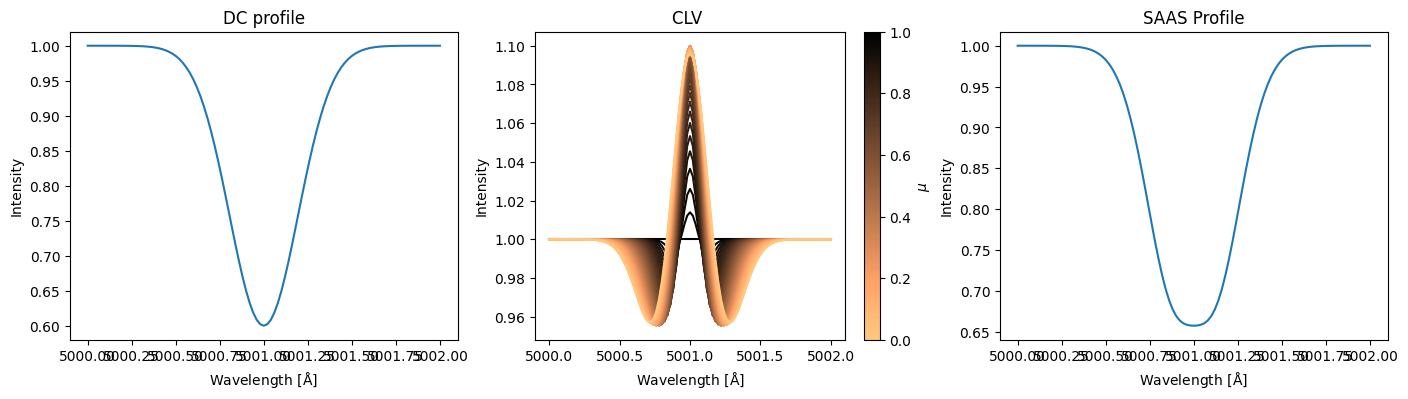

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from nessi.tester import load_data
from nessi import integrator as nss
import matplotlib.colors as mcolors
from astropy.io import fits as f
from scipy.interpolate import interp1d


wav, dc, mu, clv = load_data()
saas = nss.sun_as_a_star(nr=101)

clv += 1

print(f"There are {len(mu)} mu positions between 0 and 1.")

#Load the observed/synthetic center to limb variation (clv) and the disk center reference spectrum (dc) 
#into the solar disk. Next update the solar differential rotation velocity profile, which takes the P0 and B0 angles
#as input. Finally, calculate the integrated spectrum.

saas.update_clv(mu,wav,clv,wav,dc)
saas.update_vrot(0.,0.)
test_si = saas.get_integration()

# create colormap
cm = plt.cm.copper(np.linspace(0, 1, len(mu)))

fig = plt.subplots(1, 2, figsize=(17,4))
plt.subplot(131)
plt.plot(wav, dc)
plt.title('DC profile')
plt.xlabel(r'Wavelength [$\rm\AA$]')
plt.ylabel('Intensity')
ax =plt.subplot(132)
ax.set_prop_cycle('color', list(cm))
ax.plot(wav,clv.T)
plt.title('CLV ')
plt.xlabel(r'Wavelength [$\rm\AA$]')
plt.ylabel('Intensity')
norm = mcolors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=plt.cm.copper, norm=norm)
sm_r = plt.cm.ScalarMappable(cmap=plt.cm.copper_r, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm_r, ax=ax)
cbar.set_label(r'$\mu$')

saas.update_clv(mu,wav,clv,wav,dc)
saas.update_vrot(0.,0.)
test_si = saas.get_integration()

plt.subplot(133)
plt.plot(wav, test_si)
plt.title('SAAS Profile')
plt.xlabel(r'Wavelength [$\rm\AA$]')
plt.ylabel('Intensity')
plt.show()

# Using SST data
We can use CLV files from Pietrow et al (2023) for the quiet Sun

https://cdsarc.cds.unistra.fr/ftp/J/A+A/671/A130/fits/

We try with the 7772 Oxygen line below

Filename: 7772_clv.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  WAV           1 ImageHDU         7   (23,)   float64   
  2  MU            1 ImageHDU         7   (50,)   float64   
  3  INT           1 ImageHDU         8   (50, 23)   float64   
  4  INT_SMOOTH    1 ImageHDU         8   (50, 23)   float64   
  5  INT_VAR       1 ImageHDU         8   (50, 23)   float64   
  6  INT_COUNT     1 ImageHDU         8   (50, 23)   float64   
  7  SST_INSTRUMENT_PSF    1 ImageHDU         8   (2, 73)   float64   


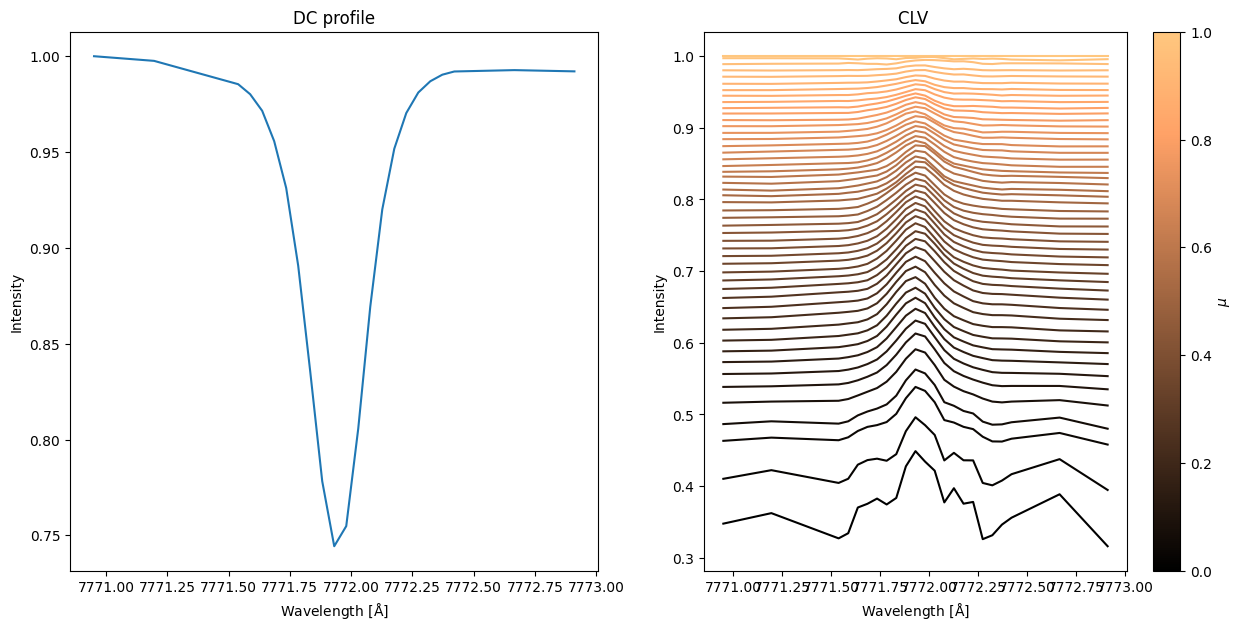

In [4]:
has = f.open('7772_clv.fits')
has.info()

sst_wav = has[1].data
sst_mu = has[2].data
sst_int = has[4].data.T

#We include an atlas to compare the data with (always good to check if all works well!)
atlas = f.getdata('solar_atlas_V1_405-1065.fits')
atlas_w = np.arange(len(atlas)) * -0.003766534468 + 24700.0858041 
aw = 1e8 / atlas_w

#Cut the atlas near where the line is (Keep in mind that we use air wavelenths, 
# and they use vacuum, so youll need to shift it)
lw = sst_wav[0]
rw = sst_wav[-1]

llw = np.where(aw > lw-3)[0][0]
lrw = np.where(aw > rw+3)[0][0]

fd = atlas[llw:lrw]
fdw = aw[llw:lrw]

ff = interp1d(fdw, fd, kind='linear', fill_value="extrapolate")
# Use this function to compute the new values
fdd = ff(sst_wav)

# CLV profiles should be normalized in such a way that at mu=0 it is is 1 all over, and the rest is above. 
sst_dc = sst_int[0]
sst_clv = sst_int.copy()
#sst_clv = sst_clv/sst_clv[0]
sst_clv /= sst_clv[0]
#sst_clv = 1/sst_clv

# We remove the intensity varitions and then place them back base on neckle and labs 
# For better accuracy in intensity
#lbd2 = np.zeros_like(sst_mu)
#for i in range(len(sst_mu)):

#    lbd2[i] = nss._limbdarkening(777.2, mu=sst_mu[i], nm=True)

#sst_clv2 = np.tile(lbd2, (23,1)).T

# Add limb darkening to CLV
#sst_clv *= lbd2[:, None]
#sst_clv = 1/sst_clv
#sst_clv2 = 1/sst_clv2
#print(sst_clv.shape, sst_clv2.shape)
    
# create colormap
cm = plt.cm.copper(np.linspace(1, 0, 50))

fig = plt.subplots(1, 2, figsize=(15,7))
plt.subplot(121)
plt.plot(sst_wav, sst_dc)
plt.title('DC profile')
plt.xlabel(r'Wavelength [$\rm\AA$]')
plt.ylabel('Intensity')

ax =plt.subplot(122)
ax.set_prop_cycle('color', list(cm))
ax.plot(sst_wav,sst_clv.T)
plt.title('CLV ')
plt.xlabel(r'Wavelength [$\rm\AA$]')
plt.ylabel('Intensity')
norm = mcolors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=plt.cm.copper, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'$\mu$')


plt.show()


Now we make a SAAS profile and roll the atlas profile to align the two

3499
crisp::read_reflectivity: (RL,RH)[7772.0] = (0.8576176912950555, 0.9227412365385039)
crisp::read_reflectivity: (RL,RH)[7772.0] = (0.8576176912950555, 0.9227412365385039)
3499


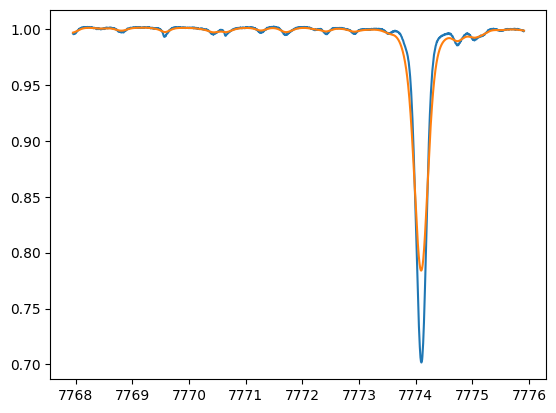

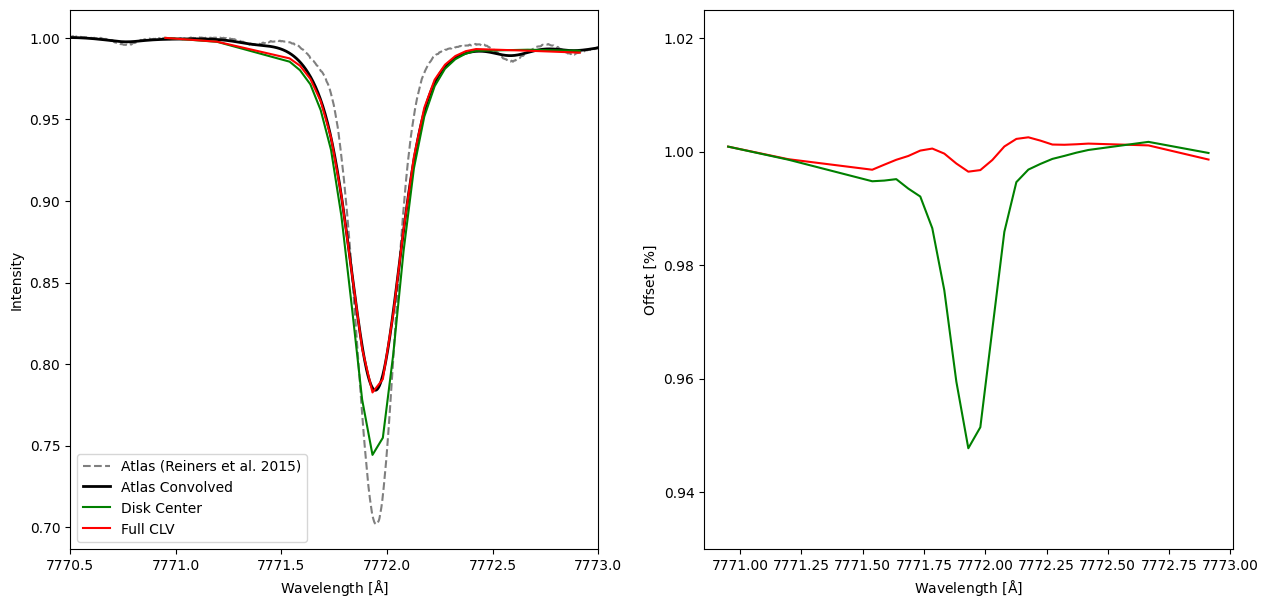

[0.99912966 0.99900019 0.99059052 0.98520907 0.97627017 0.96194512
 0.9386686  0.90285168 0.8564507  0.81109671 0.78538003 0.79334989
 0.83176915 0.88173986 0.92503585 0.95475711 0.97248091 0.98233159
 0.98769763 0.99055473 0.99175825 0.99105718 0.99234659]


In [5]:
#wav, dc, mu, clv = load_data()
saas = nss.sun_as_a_star(nr=101)
saas.update_clv(sst_mu,sst_wav,sst_clv,sst_wav,sst_dc)
saas.update_vrot(0.,0.)
test_si = saas.get_integration()

rv = -946
print(len(fdw))

#test_si = test_si/np.min(test_si)*np.min(test_si)
test_si = test_si/test_si[0]
sst_dc = sst_dc/sst_dc[0]
fdd = fdd/fdd[0]


import ISPy.spec.crisp as c
dw = 0.07
ntw = 59
tw = (np.arange(ntw)-ntw//2)*dw
fpife = c.crisp(7772)
fc = c.crisp(7772.0)
tr = fc.dual_fpi(tw, erh = -0.022) #6301-2

tr /= tr.sum()
inst_prof = np.zeros((len(tr),2))
inst_prof[:,0] = tw+np.abs(tw.min())
inst_prof[:,1] = tr

import ISPy.spec.calib as cb

aa = cb.convolve_atlas(fdw,fd,inst_prof)

aa2 = aa

print(len(fdw))

plt.plot(fdw,fd)
plt.plot(fdw,aa)
plt.show()


ff = interp1d(fdw, np.roll(aa2,rv), kind='linear', fill_value="extrapolate")
# Use this function to compute the new values
fdd = ff(sst_wav)


fig = plt.subplots(1, 2, figsize=(15,7))
plt.subplot(121)
plt.plot(fdw,np.roll(fd,rv), color='black', linestyle='--', alpha=0.5, label='Atlas (Reiners et al. 2015)')
plt.plot(fdw,np.roll(aa2,rv), color='black', lw=2, label='Atlas Convolved')
plt.plot(sst_wav, sst_dc, color='green', label='Disk Center')
plt.plot(sst_wav, test_si, color='red', label='Full CLV')
plt.xlabel(r'Wavelength [$\rm\AA$]')
plt.ylabel('Intensity')
plt.legend()
plt.xlim(7770.5,7773)

plt.subplot(122)
plt.plot(sst_wav, test_si/fdd, label='CLV', color='red')
plt.plot(sst_wav, sst_dc/fdd, label='DC', color='green')
plt.xlabel(r'Wavelength [$\rm\AA$]')
plt.ylabel('Offset [%]')

plt.ylim(0.93,1.025)
plt.show()

print(fdd)


In [13]:
# you can get the spectra of all points with this function
#This will be slow!
cube = saas.get_spectra()
cube.shape



(31316, 23)

In [14]:
#an indivudual pixel you can get by typing
px1 = saas.get_spectra_pxl(0)
#each pixel gives a spectrum and an area.
print(px1)

(array([1.00028033, 0.99762458, 0.98535823, 0.97968478, 0.97097674,
       0.95576087, 0.93157257, 0.89121176, 0.8354625 , 0.7781809 ,
       0.74405477, 0.75456057, 0.80522899, 0.86842723, 0.91892969,
       0.95076638, 0.96984411, 0.98095553, 0.9870151 , 0.99002026,
       0.99145457, 0.99191165, 0.99201462]), 0.00015707963267948965)


If you just want to add one active region that already has CLV, etc in it (e.g. an observation), you can then just multiply the SAAS profile with an average spectrum of these observations times the weight of the two. e.g. the Sun is pi*(950")^2 and the SST FOV is 60x60"

This means that your factor is:

In [15]:
factor = 60**2 / (np.pi*950**2) 
print(factor)

0.001269712565386866
